In [146]:
# Импорт необходимых библиотек

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import category_encoders as ce
from geopy.distance import geodesic
from geopy import distance
import re
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import time


In [89]:
# # def tokenezation(text):
# #     word_tokens = word_tokenize(text)
# #     return word_tokens

# def filter_stop_words(text):
#     tokens = word_tokenize(text)
#     filtered_tokens = [word for word in tokens if not word in stopwords.words('english')]
#     return filtered_tokens

# def get_lemmatize(text):
#     lemmatizer = WordNetLemmatizer()
#     tokens = word_tokenize(text)
#     lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
#     return lemmatized_words

# def get(text):
#     sia = SentimentIntensityAnalyzer()
#     return (sia.polarity_scores(text))

# # df['negative_review'] = df['negative_review'].apply(tokenezation)
# df['negative_review'] = df['negative_review'].apply(filter_stop_words)
# df['negative_review'] = df['negative_review'].apply(get_lemmatize)
# df['negative_review'] = df['negative_review'].apply(get)

In [90]:
pd.set_option('display.max_columns', None)

# зафиксируем версию пакетов, random_seed, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
RANDOM_SEED = 42

# Загружаем данные:
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

In [91]:
# Объединив датасеты для обучения и предсказания, видим пропуски в двух столбцах: с широтой (lat) и долготой (lng) расположения отеля. 
# Пропуски так же есть в целевом признаке из-за объединения тестовой и тренировочной выборки, которые мы не будем обрабатывать. 

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [92]:
# Для того, чтобы заполнить данные в пропущенных значениях, создадим два признака из адреса отеля - страну и город.

# Функция для получения признака "Страна"
def get_country(address):
    country = address.split(' ')[-2:]
    country = str(country).replace(',', '').replace("['", "").replace("']", "").replace("'", "")
    if country == 'United Kingdom':
        return 'United Kingdom'
    if country == 'Paris France':
        return 'France'
    if country == 'Amsterdam Netherlands':
        return 'Netherlands'
    if country == 'Milan Italy':
        return 'Italy'
    if country == 'Vienna Austria':
        return 'Austria'
    if country == 'Barcelona Spain':
        return 'Spain'
    else:
        return 'other'
    
df['country'] = df['hotel_address'].apply(get_country)

# Функция для получения признака "Город"
def city(country):
    if country == 'United Kingdom':
        return 'London'
    if country == 'France':
        return 'Paris'
    if country == 'Netherlands':
        return 'Amsterdam'
    if country == 'Italy':
        return 'Milan'
    if country == 'Austria':
        return 'Vienna'
    if country == 'Spain':
        return 'Barcelona'

df['city'] = df['country'].apply(city)

In [93]:
# Так как уникальных значений стран в наших данных немного, 
# восстановлю данные о координатах модальным значениями по стране (а значит по городу, в к-м расположен отель,
# так как отели из нашей выборки расположены все в столицах)

# Сгруппирую данные для получения нужныз модальных значений
df.groupby(['country'])['lng'].agg(pd.Series.mode)
df.groupby(['country'])['lat'].agg(pd.Series.mode)

country
Austria           48.214662
France            48.879484
Italy             45.533137
Netherlands       52.370545
Spain             41.371308
United Kingdom    51.501910
Name: lat, dtype: float64

In [94]:
# Заполню пропуски полученными на предыдущем шаге данными:
df[df['country'] == 'Austria'] = df[df['country'] == 'Austria'].fillna({'lng':16.362799, 'lat':48.214662})
df[df['country'] == 'France'] = df[df['country'] == 'France'].fillna({'lng':2.355654, 'lat':48.879484})
df[df['country'] == 'Italy'] = df[df['country'] == 'Italy'].fillna({'lng':9.171102, 'lat':45.533137})
df[df['country'] == 'Netherlands'] = df[df['country'] == 'Netherlands'].fillna({'lng':4.888644, 'lat':52.370545})
df[df['country'] == 'Spain'] = df[df['country'] == 'Spain'].fillna({'lng':2.181698, 'lat':41.371308})
df[df['country'] == 'United Kingdom'] = df[df['country'] == 'United Kingdom'].fillna({'lng':-0.023221, 'lat':51.501910})

In [95]:
# Создаю: 1) признак с координатами отеля;   
# 2) признак с координатами центра города (за центр города я брала координаты с Google Maps, по точке в центре города)

def get_coordinate(lat, lng):
    return (float(lat), float(lng))

def capital_coordinate(country):
    if country == 'United Kingdom':
        return (float(51.50936092785646), float(-0.12416095345639586))
    if country == 'France':
        return (float(48.853229), float(2.342797))
    if country == 'Netherlands':
        return (float(52.37176471692262), float(4.895930820099642))
    if country == 'Italy':
        return (float(45.46986), float(9.18499))
    if country == 'Austria':
        return (float(48.20471741160276), float(16.37049992180316))
    if country == 'Spain':
        return (float(41.395704279217775), float(2.172020436193314))
        

df['hotel_coordinate'] = df.apply(lambda row: get_coordinate(row['lat'], row['lng']), axis = 1)
df['center_coordinate'] = df['country'].apply(capital_coordinate)

<AxesSubplot: >

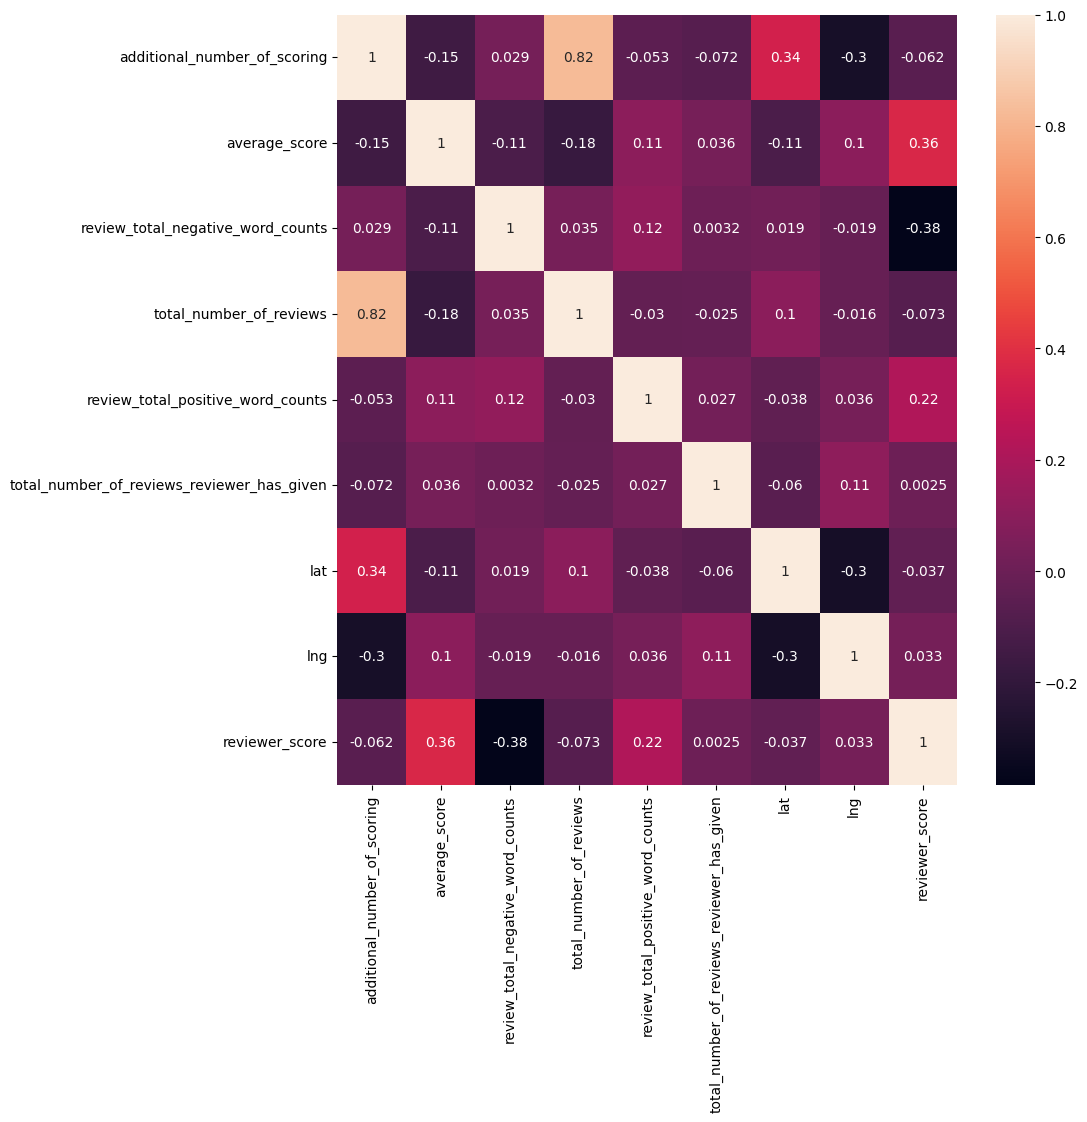

In [96]:
# Посмотрим на тепловую матрицу корреляции числовых признаков:

sns.heatmap(df.corr(), annot = True)

Анализирую матрицу корреляции числовых признаков мы видем сильную зависимость между признаками "additional_number_of_scoring" и "total_number_of_reviews". От одного из этих признаков нам необходимо избавиться. 
оставим признак, который имеет бОльшую взаимосвязь с целевой переменной.
Исходя из корреляции по методу Пирсона, следует избавиться от "additional_number_of_scoring", так как взаимосвязь "total_number_of_reviews" и 'reviewer_score' проявляется больше.
Однако, проверим нормальность распределения двух этих признаков.

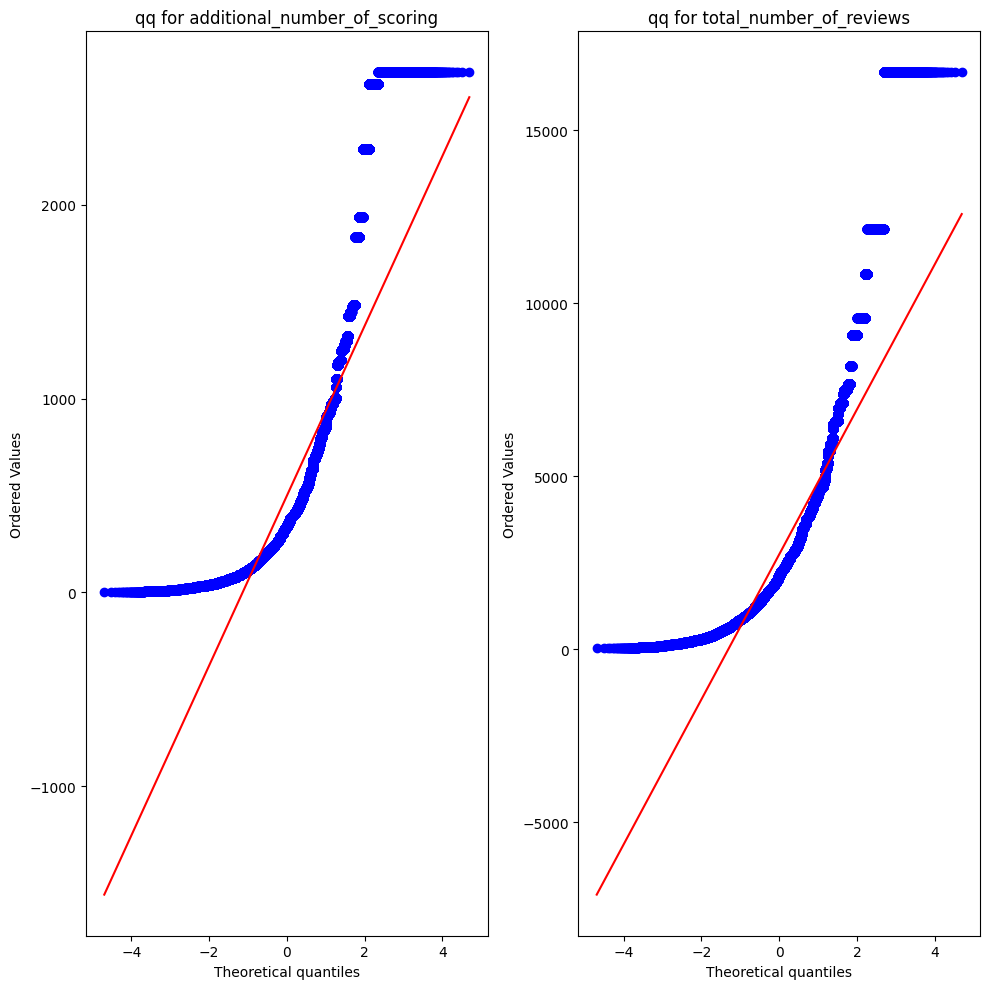

In [97]:
# Построим qq plot графики для двух признаков, чтобы оценить нормальность их распределения.

plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(df['additional_number_of_scoring'], plot=plt) # qq plot
plt.title('qq for additional_number_of_scoring')

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
stats.probplot(df['total_number_of_reviews'], plot=plt) # qq plot
plt.title('qq for total_number_of_reviews')

plt.tight_layout() 
plt.show() 

<AxesSubplot: >

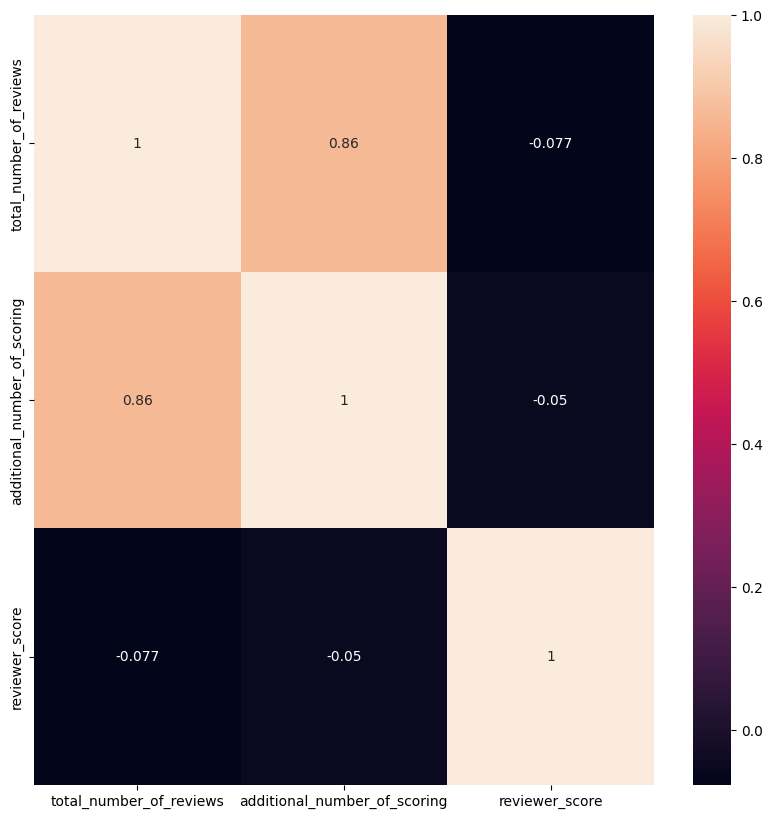

In [98]:
# Исходя из qq plot графиков выше, можно сказать, что показатели распределены ненормально. 
# Оценим взаимосвязь этих признаков с целевой переменной, использую метод Спирмена.

sns.heatmap(df[['total_number_of_reviews', 'additional_number_of_scoring', 'reviewer_score']].corr(method = 'spearman'), annot = True)


In [99]:
# Взаимосвязь признаков "total_number_of_reviews" и 'reviewer_score' при данном методе корреляции видна еще сильнее.
# C помощью статичстического теста проверим равенство диспрерсий для того, 
# чтобы понять какой тест использовать для проверки взаимосвязи признаков - параметрический или непараметрический.

# задаём уровень значимости
alpha = 0.05
result = stats.levene(df['total_number_of_reviews'], df['additional_number_of_scoring'])
p = result[1]
print('p-value = {:.3f}'.format(p))

if p <= alpha:
    print('Дисперсии не одинаковы, нужно использовать непараметрический тест')
else:
    print('Дисперсии одинаковы, мы можем использовать тест ANOVA')


p-value = 0.000
Дисперсии не одинаковы, нужно использовать непараметрический тест


In [100]:
# Дисперсии не одинаковы, нужно использовать непараметрический тест. Воспользуемся тестом хм-квадрат для проверки взаимосвязи между признаками.
# Сформулируем гипотезы:
# Нулевая гипотеза: признаки 'total_number_of_reviews'] и 'additional_number_of_scoring' независимы.
# Альтернативная гипотеза: признаки 'total_number_of_reviews'] и 'additional_number_of_scoring' взаимосвязаны.

# задаём уровень значимости
alpha = 0.05 

# вычисляем таблицу сопряжённости
table = pd.crosstab(df['total_number_of_reviews'], df['additional_number_of_scoring'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


In [101]:
# p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу. Признаки зависимы.
# Так как признак 'total_number_of_reviews' имееет большую корреляцию с целевой переменной, удалим признак "additional_number_of_scoring" из наших данных.

df = df.drop("additional_number_of_scoring", axis = 1)

In [102]:
# Из признака даты получим два новых признака - год и месяц. Так же создадаим признак сезона.

df['review_date'] = pd.to_datetime(df['review_date'])
df['year'] = df['review_date'].dt.year
df['month'] = df['review_date'].dt.month


def get_season(data):
    if data in [12, 1, 2]:
        return 'winter'
    if data in [3, 4, 5]:
        return 'spring'
    if data in [6, 7, 8]:
        return 'summer'
    if data in [9, 10, 11]:
        return 'autumn'
    
df['season'] = df['month'].apply(get_season)

In [103]:
df.corr()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,year,month
average_score,1.000000,-0.112323,-0.179568,0.106719,0.036454,-0.108319,0.099847,0.363915,0.015536,-0.009889
review_total_negative_word_counts,-0.112323,1.000000,0.035124,0.119613,0.003199,0.019119,-0.019455,-0.383407,0.039746,-0.008877
total_number_of_reviews,-0.179568,0.035124,1.000000,-0.030132,-0.024910,0.101253,-0.015953,-0.073389,-0.004127,-0.004345
review_total_positive_word_counts,0.106719,0.119613,-0.030132,1.000000,0.026535,-0.037691,0.035588,0.220294,0.048608,-0.027519
total_number_of_reviews_reviewer_has_given,0.036454,0.003199,-0.024910,0.026535,1.000000,-0.059753,0.111989,0.002498,-0.034538,0.013464
lat,-0.108319,0.019119,0.101253,-0.037691,-0.059753,1.000000,-0.302565,-0.036837,0.009755,-0.023668
lng,0.099847,-0.019455,-0.015953,0.035588,0.111989,-0.302565,1.000000,0.032560,-0.010830,0.024901
reviewer_score,0.363915,-0.383407,-0.073389,0.220294,0.002498,-0.036837,0.032560,1.000000,0.011043,-0.032397
year,0.015536,0.039746,-0.004127,0.048608,-0.034538,0.009755,-0.010830,0.011043,1.000000,-0.581331
month,-0.009889,-0.008877,-0.004345,-0.027519,0.013464,-0.023668,0.024901,-0.032397,-0.581331,1.000000


In [104]:
# Обработаем признак 'reviewer_nationality', убрав пробелы, для удобства кодирования данного признака.

df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x.strip())
df['reviewer_nationality'].nunique()

227

In [105]:
# Преобразуем признак 'days_since_review', оставив только число - количество дней: 

df['days_since_review'] = df['days_since_review'].apply(lambda x: str(x.split(' ')[:1]).replace("'", '').replace("'", '').replace('[', '').replace(']', ''))
df['days_since_review'] = df['days_since_review'].astype('float64')                                              

In [106]:
# Создаю признак с расстоянием от центра города до отеля 

from geopy import distance

def dist_from_cent(hotel_coordinate, center_coordinate):
    return geodesic(hotel_coordinate, center_coordinate).kilometers

df['dist_from_cent_km'] = round(df.apply(lambda row: dist_from_cent(row['hotel_coordinate'], row['center_coordinate']),  axis = 1))

In [107]:

# df = df.drop('center_coordinate', axis = 1)
# df = df.drop('hotel_coordinate', axis = 1)

# Чтото пошло не так с попыткой нормализовать признаки:

# col_names = ['days_since_review', 'additional_number_of_scoring', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given']

# from sklearn import preprocessing
# r_scaler = preprocessing.RobustScaler()

# r_scaler = preprocessing.RobustScaler()
# df_r = r_scaler.fit_transform(feature_df)

# df_r = pd.DataFrame(df_r, columns=col_names)

# fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
# ax1.set_title('Распределения после RobustScaler')

# sns.kdeplot(df_r)


In [108]:
feature_df.corr(method = 'spearman')

,month,year,reviewer_score,season_summer,season_winter,season_autumn,season_spring
month,1.000000,-0.583933,-0.032851,0.102563,-0.250247,0.590398,-0.439794
year,-0.583933,1.000000,0.017323,0.079839,0.064893,-0.473243,0.317639
reviewer_score,-0.032851,0.017323,1.000000,-0.005678,0.030821,-0.035794,0.010923
season_summer,0.102563,0.079839,-0.005678,1.000000,-0.341126,-0.345036,-0.360271
season_winter,-0.250247,0.064893,0.030821,-0.341126,1.000000,-0.307133,-0.320694
season_autumn,0.590398,-0.473243,-0.035794,-0.345036,-0.307133,1.000000,-0.324370
season_spring,-0.439794,0.317639,0.010923,-0.360271,-0.320694,-0.324370,1.000000


In [109]:
# Посмотрим на категориальные и числовые признаки

cat_cols = []
num_cols = []

for col in df.columns:
    if df[col].dtypes == 'object':
        cat_cols.append(col)
    else:
        num_cols.append(col)
        
print('Категориальные признаки:', cat_cols)
print('Числовые признаки', num_cols)

Категориальные признаки: ['hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'country', 'city', 'hotel_coordinate', 'center_coordinate', 'season']
Числовые признаки ['review_date', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng', 'reviewer_score', 'year', 'month', 'dist_from_cent_km']


In [110]:
feature_df = df.copy()
feature_df = feature_df.drop(['hotel_address', 'hotel_name', 'review_date', 'negative_review', 'positive_review', 'country', 'season', 'reviewer_nationality', 'tags', 'lat', 'lng', 'city', 'hotel_coordinate', 'center_coordinate'], axis = 1)

In [111]:
feature_df
cat_cols = feature_df.columns.to_list()
# del cat_cols[:7]
# del cat_cols[1:4]
cat_cols

['average_score',
 'hotel_name',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'days_since_review',
 'reviewer_score',
 'year',
 'month',
 'dist_from_cent_km']

In [112]:
feature_df[cat_cols].corr(method = 'spearman')

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,year,month,dist_from_cent_km
average_score,1.000000,-0.158579,-0.193501,0.139149,0.040756,-0.014095,0.356856,0.014767,-0.008845,-0.254018
review_total_negative_word_counts,-0.158579,1.000000,0.051824,0.022837,0.007960,-0.045261,-0.470300,0.041265,-0.009898,0.061431
total_number_of_reviews,-0.193501,0.051824,1.000000,-0.039901,-0.038596,0.021496,-0.076538,-0.016968,-0.003652,0.128840
review_total_positive_word_counts,0.139149,0.022837,-0.039901,1.000000,0.047334,-0.017829,0.311376,0.024354,-0.024121,-0.027573
total_number_of_reviews_reviewer_has_given,0.040756,0.007960,-0.038596,0.047334,1.000000,0.036594,-0.026483,-0.038682,0.020865,-0.060708
days_since_review,-0.014095,-0.045261,0.021496,-0.017829,0.036594,1.000000,-0.005332,-0.911589,0.202993,-0.015181
reviewer_score,0.356856,-0.470300,-0.076538,0.311376,-0.026483,-0.005332,1.000000,0.017323,-0.032851,-0.101763
year,0.014767,0.041265,-0.016968,0.024354,-0.038682,-0.911589,0.017323,1.000000,-0.583933,0.015256
month,-0.008845,-0.009898,-0.003652,-0.024121,0.020865,0.202993,-0.032851,-0.583933,1.000000,-0.006271
dist_from_cent_km,-0.254018,0.061431,0.128840,-0.027573,-0.060708,-0.015181,-0.101763,0.015256,-0.006271,1.000000


In [114]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) 
type_bin = bin_encoder.fit_transform(df['reviewer_nationality'])
feature_df = pd.concat([feature_df, type_bin], axis=1)

import category_encoders as ce
encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True)
type_bin = encoder.fit_transform(df['country'])
feature_df = pd.concat([feature_df, type_bin], axis=1)


season_encoder = ce.OneHotEncoder(cols=['season'], use_cat_names=True) 
season_bin = season_encoder.fit_transform(df['season'])
feature_df = pd.concat([feature_df, season_bin], axis=1)

season_encoder = ce.OneHotEncoder(cols=['month'], use_cat_names=True) 
season_bin = season_encoder.fit_transform(df['month'])
feature_df = pd.concat([feature_df, season_bin], axis=1)

In [127]:
# У нас есть три признака, относящиеся к дате, когда была дана оценка отелю: год, месяц, сезон.
# Посмотри на корреляцию данных признаков с целевой переменной:

df[['month', 'year', 'reviewer_score']].corr()

# Признак месяца имеет большую корреляцию с целевой переменной, чем год. 
# Что важнее для модели - месяц или сезон? 
# С помощью RandomForestRegressor после обучения модели и получения значение МАРЕ, выведем самые важные признаки.

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,year,month,dist_from_cent_km,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,season_summer,season_winter,season_autumn,season_spring,month_7.0,month_12.0,month_11.0,month_10.0,month_5.0,month_8.0,month_6.0,month_9.0,month_1.0,month_3.0,month_4.0,month_2.0
0,8.1,52,16670,62,1,13.0,NaN,2017,7,7.0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,8.6,10,5018,0,7,234.0,NaN,2016,12,4.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,8.3,3,351,5,15,616.0,NaN,2015,11,1.0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,9.1,0,1543,27,9,656.0,NaN,2015,10,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,9.1,0,4687,7,2,444.0,NaN,2016,5,1.0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9.0,0,617,10,10,106.0,8.8,2017,4,5.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
515734,8.4,0,3224,93,1,171.0,9.2,2017,2,3.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
515735,6.8,12,2751,9,21,543.0,8.3,2016,2,1.0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
515736,8.1,0,1567,6,28,74.0,9.2,2017,5,3.0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


<AxesSubplot: >

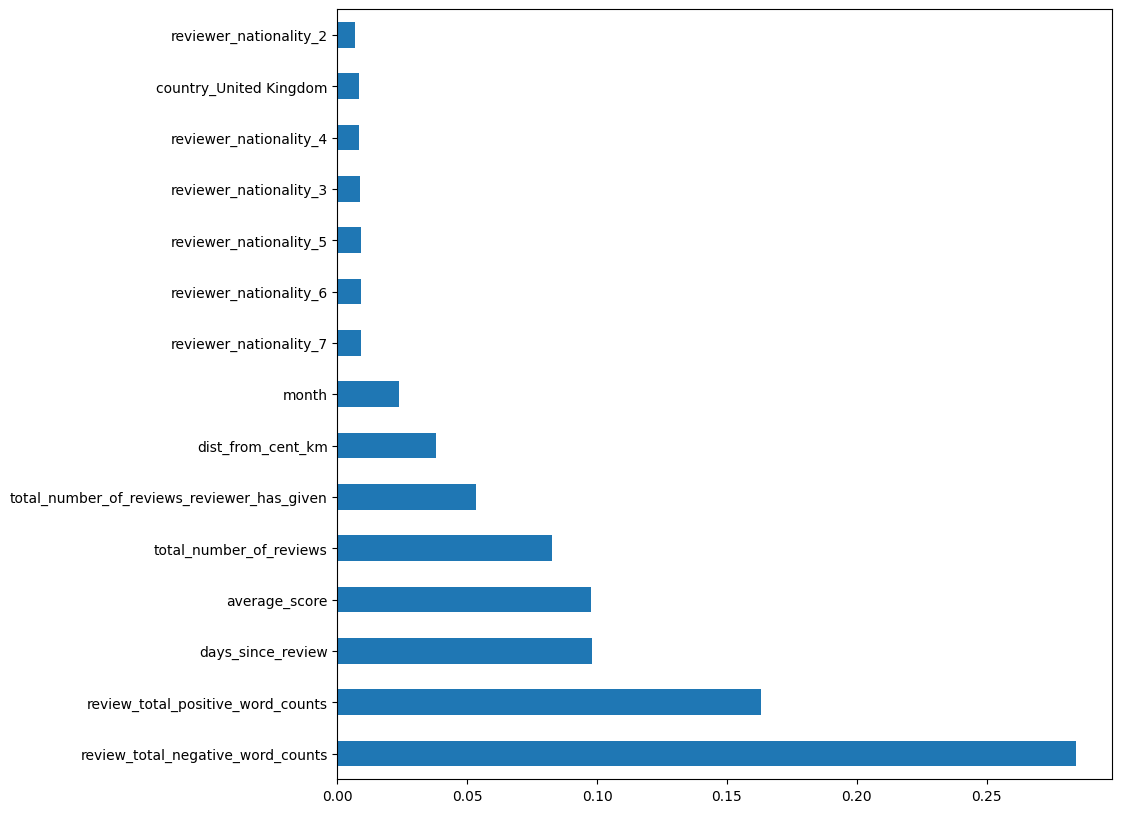

In [125]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Мы получили значение МАРЕ, а так же возможность посмотреть на самые важные признаки для модели. 
Данные о сезоне не являются одними из важных. Удалим их.
Так же проведем нормализацю некоторых признаков, после чего посмотрим на результат МАРЕ еще раз.

In [136]:
feature_df = feature_df.drop(['season_spring', 'season_autumn', 'season_summer', 'season_winter'], axis = 1)
feature_df = feature_df.drop(['month'], axis = 1)
feature_df = feature_df.drop(['year'], axis = 1)

In [141]:
feature_df

days_since_review	
total_number_of_reviews


,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,dist_from_cent_km,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,month_7.0,month_12.0,month_11.0,month_10.0,month_5.0,month_8.0,month_6.0,month_9.0,month_1.0,month_3.0,month_4.0,month_2.0
0,8.1,52,16670,62,1,13.0,NaN,7.0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,8.6,10,5018,0,7,234.0,NaN,4.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,8.3,3,351,5,15,616.0,NaN,1.0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,9.1,0,1543,27,9,656.0,NaN,1.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,9.1,0,4687,7,2,444.0,NaN,1.0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9.0,0,617,10,10,106.0,8.8,5.0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
515734,8.4,0,3224,93,1,171.0,9.2,3.0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
515735,6.8,12,2751,9,21,543.0,8.3,1.0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
515736,8.1,0,1567,6,28,74.0,9.2,3.0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


<AxesSubplot: ylabel='Density'>

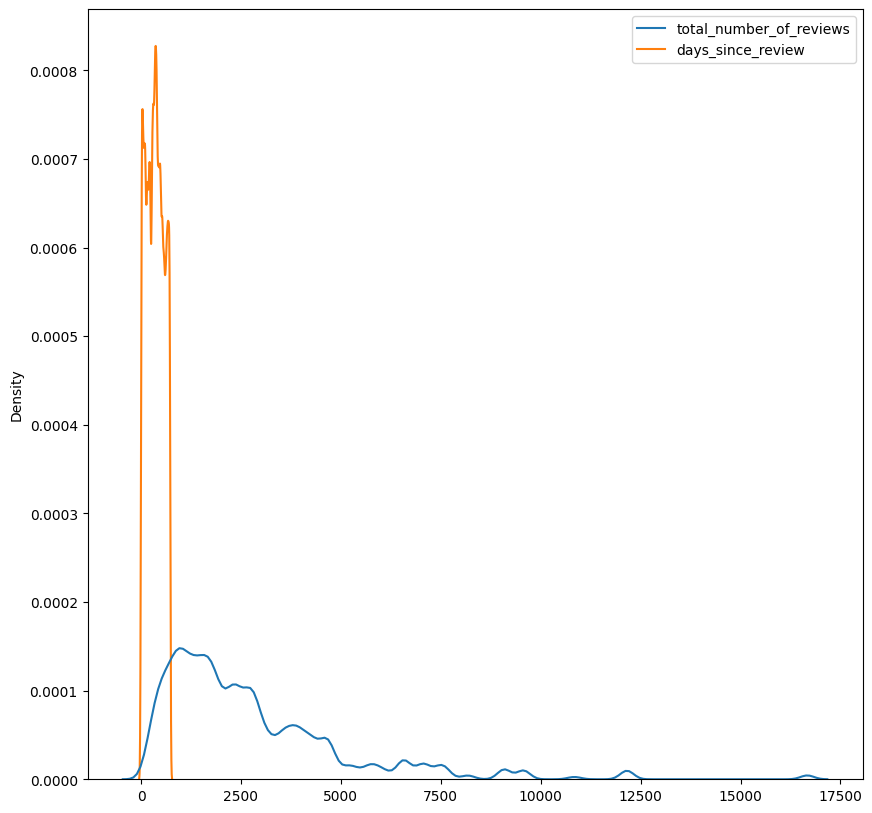

In [ ]:
sns.kdeplot(feature_df)

In [151]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
df_r = r_scaler.fit_transform(feature_df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=list(feature_df.columns))


,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,dist_from_cent_km,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,month_7.0,month_12.0,month_11.0,month_10.0,month_5.0,month_8.0,month_6.0,month_9.0,month_1.0,month_3.0,month_4.0,month_2.0
0,-0.428571,2.047619,5.928222,3.000000,-0.285714,-0.965909,NaN,1.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.285714,0.047619,1.176183,-0.647059,0.571429,-0.338068,NaN,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.142857,-0.285714,-0.727162,-0.352941,1.714286,0.747159,NaN,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,-0.428571,-0.241028,0.941176,0.857143,0.860795,NaN,-0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,-0.428571,1.041191,-0.235294,-0.142857,0.258523,NaN,-0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,0.857143,-0.428571,-0.618679,-0.058824,1.000000,-0.701705,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
515734,0.000000,-0.428571,0.444535,4.823529,-0.285714,-0.517045,0.190476,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
515735,-2.285714,0.142857,0.251631,-0.117647,2.571429,0.539773,-0.238095,-0.333333,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
515736,-0.428571,-0.428571,-0.231240,-0.294118,3.571429,-0.792614,0.190476,0.333333,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
sns.kdeplot(feature_df)

In [155]:
train_data = df_r[df_r['reviewer_score'].isnull() == False]
test_data = df_r[df_r['reviewer_score'].isnull() == True]

X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'] 

from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

In [ ]:
train_data = df_r[df_r['reviewer_score'].isnull() == False]
test_data = df_r[fdf_r['reviewer_score'].isnull() == True]

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))
